## Setup

In [ ]:
# !pip install einops
# !pip install osmnx geopandas folium matplotlib

In [61]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image
import osmnx as ox
import geopandas as gpd

from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor

In [2]:
to_tensor = [Resize((144, 144)), ToTensor()]
''' Purpose: Prepares images for training.
 Resize((144, 144)): Resizes images to 144x144 pixels.
 ToTensor(): Converts a PIL image or numpy array to a PyTorch tensor (and scales pixel values to [0, 1]) '''

' Purpose: Prepares images for training.\n Resize((144, 144)): Resizes images to 144x144 pixels.\n ToTensor(): Converts a PIL image or numpy array to a PyTorch tensor (and scales pixel values to [0, 1]) '

### Compose Class

In [3]:
''' Purpose: Chains multiple transformations together (similar to torchvision.transforms.Compose).
 Key Difference: This version retains the target (e.g., class labels/bounding boxes) alongside the transformed image, which is useful for tasks like segmentation or object detection.
'''

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms  # List of transformations (e.g., `to_tensor`).

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)  # Apply each transform sequentially.
        return image, target

### Display grid sample

In [9]:
'''Purpose: Displays a grid of num_samples images from the dataset.
 Notes:
 to_pil_image: Converts a PyTorch tensor back to a PIL image for Matplotlib compatibility.
 Assumes img[0] is the image tensor (useful if the dataset returns (image, target) tuples).'''
def show_images(images, num_samples=40, cols=8):
    """Plots samples from the dataset."""
    plt.figure(figsize=(15, 15))
    idx = int(len(dataset) / num_samples)
    for i, img in enumerate(images):
        if i % idx == 0:  # Sample images at intervals.
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.imshow(to_pil_image(img[0]))  # Convert tensor to PIL image for display.

### Load data example -> Road to Amsterdam

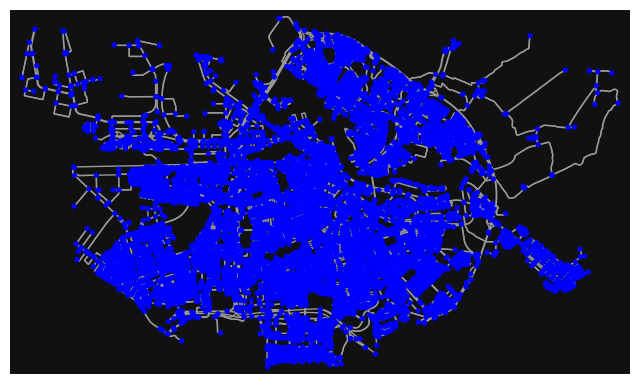

In [15]:
# Download streets in Amsterdam
G = ox.graph_from_place('Amsterdam, Netherlands', network_type='drive')

# Save as GraphML (XML-based format for graph data)
ox.save_graphml(G, filepath='data/amsterdam_roads.graphml')

# Load back the saved data
G = ox.load_graphml('data/amsterdam_roads.graphml')

# Plot
fig, ax = ox.plot_graph(G, node_color='blue', edge_linewidth=1)
plt.show()

### Load data example region

In [33]:
# 1. Download OSM road network
G = ox.graph_from_place('Amsterdam, Netherlands', network_type="drive")  

# 2. Convert to GeoJSON
roads = ox.graph_to_gdfs(G, nodes=False, edges=True)
roads.to_file('data/amsterdam_roads.geojson', driver='GeoJSON')  # Creates the file

In [29]:
print(ox.__version__)

2.0.2


In [48]:
# 1. Load Amsterdam polygons (e.g., buildings)
gdf = ox.features_from_place('Amsterdam, Netherlands', tags={'building': True})
gdf_polygons = gpd.GeoDataFrame(gdf, geometry='geometry', crs='EPSG:4326')

gdf_polygons.to_file('data/amsterdam_region.geojson', driver='GeoJSON')

### Dataset Load

In [49]:
dataset = gpd.read_file('data/amsterdam_region.geojson')
dataset.head()

,element,id,amenity,building,email,name,operator,phone,religion,website,...,organic,payment:qr_code,self_checkout,contact:fax,name:mk,castle_type,name:lb,train,zone,geometry
0,node,26654662,place_of_worship,mosque,rvm_nh@planet.nl,El-Mouhsininne,RVM Noord Holland,+31 20 634 2918,muslim,https://www.rvmm.nl/,...,None,None,None,None,None,None,None,None,None,POINT (4.91312 52.38328)
1,node,30118637,fuel,yes,None,BP,Kriterion Studentenpomp,None,None,https://map.bp.com/nl-NL/NL/tankstation/amster...,...,None,None,None,None,None,None,None,None,None,POINT (4.97073 52.36888)
2,node,353029953,None,public,None,buurtveiligheidspunt,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (4.90639 52.35053)
3,node,593473488,None,yes,None,Marechaussee-kantoor,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (4.92048 52.37463)
4,node,764229151,None,public,None,Cascade,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (4.85374 52.35385)


Text(0.5, 1.0, 'Full Region in Amsterdam')

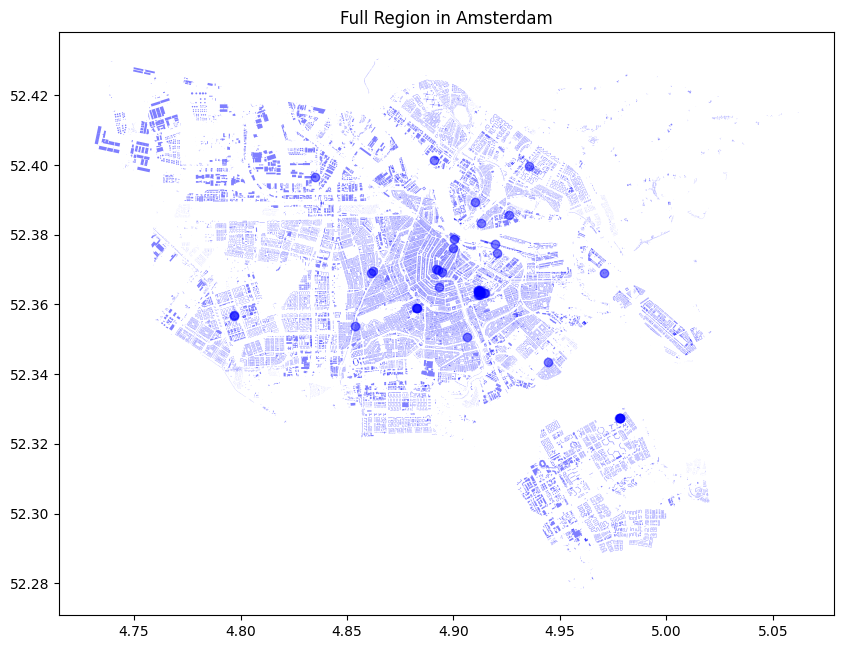

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))
dataset['geometry'].plot(ax=ax, color='blue', alpha=0.5)
plt.title('Full Region in Amsterdam')

### sample 200 random region

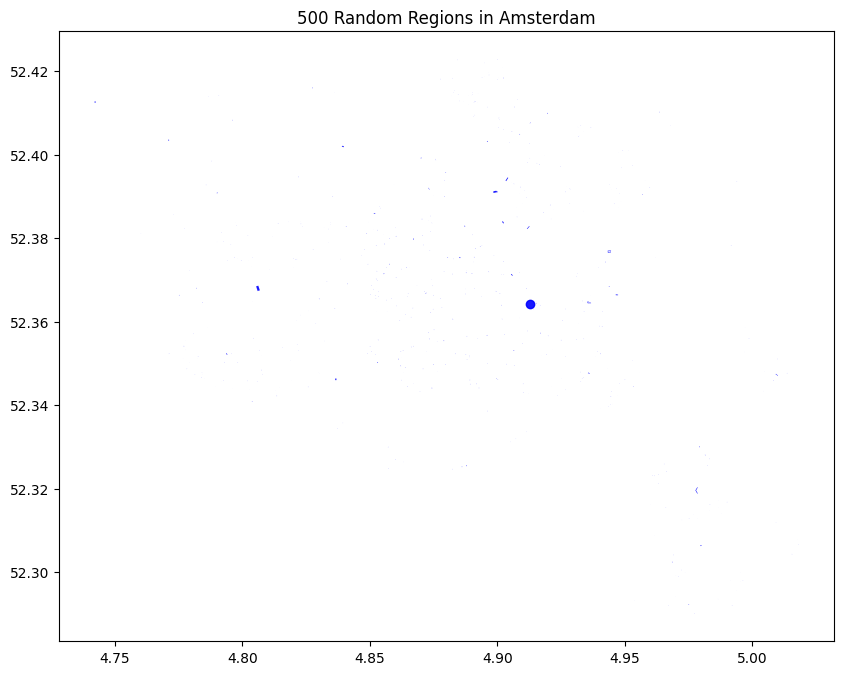

In [ ]:
sample_data = dataset.sample(n=500)
fig, ax = plt.subplots(figsize=(10, 10))
sample_data['geometry'].plot(ax=ax, color='blue', alpha=0.9)
plt.title("500 Random Regions in Amsterdam")
plt.savefig("data/amsterdam_sample.png", dpi=250)
plt.show()

## Patch Images

In [62]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=8, emb_size=128):
        """
        Initialize the Patch Embedding layer.
        
        Args:
            in_channels: Number of input channels (3 for RGB)
            patch_size: Size of each square patch (both height and width)
            emb_size: Output embedding size for each patch
        """
        super().__init__()
        self.patch_size = patch_size
        
        print("\n=== Initializing PatchEmbedding ===")
        print(f"Input channels: {in_channels}")
        print(f"Patch size: {patch_size}")
        print(f"Embedding size: {emb_size}")
        
        # Create the projection sequence that will:
        # 1. Rearrange image into patches
        # 2. Linearly project patches to embedding dimension
        self.projection = nn.Sequential(
            # Using einops Rearrange to split image into flattened patches
            # 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)' means:
            # - b: batch dimension
            # - c: channels dimension
            # - (h p1): split height into h parts of size p1 (patch height)
            # - (w p2): split width into w parts of size p2 (patch width)
            # Output will be: batch × num_patches × flattened_patch_with_channels
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', 
                     p1=patch_size, p2=patch_size),
            
            # Linear layer to project flattened patches to embedding dimension
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
        
        print("Projection layer initialized:")
        print(self.projection)

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the PatchEmbedding.
        
        Args:
            x: Input tensor of shape (batch, channels, height, width)
        
        Returns:
            Tensor of shape (batch, num_patches, emb_size)
        """
        print("\n=== Forward Pass ===")
        print(f"Input shape: {x.shape}")
        
        # Apply projection (both patch creation and linear projection)
        x = self.projection(x)
        
        print("After projection:")
        print(f"Output shape: {x.shape}")
        
        return x

# Test code with more detailed prints
def test_patch_embedding():
    print("\n=== Starting Test ===")
    
    # Create a dummy image tensor with shape (batch_size, channels, height, width)
    # We'll modify the test to use clearer dimensions
    batch_size = 2
    channels = 3
    height = 32
    width = 32
    patch_size = 8
    
    dummy_image = torch.randn(batch_size, channels, height, width)
    print("\nCreated dummy image:")
    print(f"Shape: {dummy_image.shape} (batch, channels, height, width)")
    print(f"Tensor values example (first pixel): {dummy_image[0, 0, 0, :5]}...")
    
    # Initialize the PatchEmbedding class
    print("\nInitializing PatchEmbedding...")
    patch_embedding = PatchEmbedding(
        in_channels=channels,
        patch_size=patch_size,
        emb_size=128
    )
    
    # Pass the dummy image through the PatchEmbedding class
    print("\nProcessing image through PatchEmbedding...")
    embedding = patch_embedding(dummy_image)
    
    # More detailed output
    print("\n=== Final Output ===")
    print(f"Number of patches: {height//patch_size * width//patch_size}")
    print(f"Final embedding shape: {embedding.shape}")
    
    # Example patch values
    print("\nExample of first few patch embeddings:")
    print(embedding[0, :3, :5])  # Print first 3 patches, first 5 dimensions

if __name__ == "__main__":
    test_patch_embedding()


=== Starting Test ===

Created dummy image:
Shape: torch.Size([2, 3, 32, 32]) (batch, channels, height, width)
Tensor values example (first pixel): tensor([ 0.9320, -0.6913, -1.8305,  0.3973, -1.9623])...

Initializing PatchEmbedding...

=== Initializing PatchEmbedding ===
Input channels: 3
Patch size: 8
Embedding size: 128
Projection layer initialized:
Sequential(
  (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
  (1): Linear(in_features=192, out_features=128, bias=True)
)

Processing image through PatchEmbedding...

=== Forward Pass ===
Input shape: torch.Size([2, 3, 32, 32])
After projection:
Output shape: torch.Size([2, 16, 128])

=== Final Output ===
Number of patches: 16
Final embedding shape: torch.Size([2, 16, 128])

Example of first few patch embeddings:
tensor([[ 0.2943, -0.2801,  0.7910, -0.0763, -0.1740],
        [ 0.0457, -0.0265, -1.4576, -0.7138, -0.4145],
        [-1.0449,  0.9185, -0.1290, -0.8238, -0.5518]],
       grad_fn=<SliceBackward0>)


####
1. Input Image Creation
Shape: A batch of 2 RGB images (3 channels), each 32x32 pixels.
 Example Tensor Values: Randomly generated pixel values (normalized around 0). The first 5 values from the first pixel in the first image are shown as an example.

2. Patch Embedding Initialization
 Patch Size (8): Divides the 32x32 image into 8x8 patches.
 Embedding Size (128): Each patch will be converted into a 128-dimensional vector.
 Projection Layer consists of two steps:
 Rearrange (EinOps): Splits the image into flattened patches.
 Linear Layer: Projects each flattened patch into 128 dimensions.
 Math Behind It
 Input to Linear Layer (in_features=192):
 Each patch is 8x8x3 (height × width × RGB channels → 192 values).
 Output (out_features=128):
 Each 8x8 patch is compressed into a 128-D vector.

3. Forward Pass Execution
 Input (2, 3, 32, 32) → Batch of 2 images (3×32×32 each).
 Rearrange Into Patches:
 (32 height) / (8 patch size) = 4 patches vertically
 (32 width) / (8 patch size) = 4 patches horizontally
 → Total Patches per Image: 4 × 4 = 16
 Final Shape (2, 16, 128):
 2 images (batch size),
 16 patches per image,
 128-D embedding per patch. 

4. Final Output Example
 This shows the first 5 dimensions of the first 3 patches for an example image.
 Each row represents one patch.
 Each value comes from the Linear layer's output (128-D embedding).
####

### Model

#### Class Definition and Initialization

In [ ]:
from einops import rearrange  # Used for tensor reshaping (not used here but common in attention layers)

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads  # Number of attention heads

        # PyTorch’s built-in multi-head attention layer. Computes scaled dot-product attention across n_heads.
        self.att = torch.nn.MultiheadAttention(
            embed_dim=dim,       # Input embedding dimension (e.g., 128)
            num_heads=n_heads,   # Parallel attention heads (e.g., 8)
            dropout=dropout      # Dropout rate for attention weights (e.g., 0.1)
        )
        # Linear layers for Query (q), Key (k), Value (v) projections
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

        # Linear layers to project inputs into Query (Q), Key (K), and Value (V) matrices. These learn separate representations for attention computation.

#### Forward Pass

In [65]:
def forward(self, x):
    # Project input into Query (Q), Key (K), Value (V) matrices
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    # Transforms input x into Q, K, V using linear projections. This allows the model to learn different representations for attention.

    # Compute attention:
    # - Inputs: Query, Key, Value (all `x` for self-attention)
    # - Output: Attended features + attention weights (ignored here)
    attn_output, attn_output_weights = self.att(x, x, x)
    return attn_output

''' Computes scaled dot-product attention:
 1. Q and K produce attention scores (weights).
 2. Weights applied to V to produce context-aware output. '''

' Computes scaled dot-product attention:\n 1. Q and K produce attention scores (weights).\n 2. Weights applied to V to produce context-aware output. '

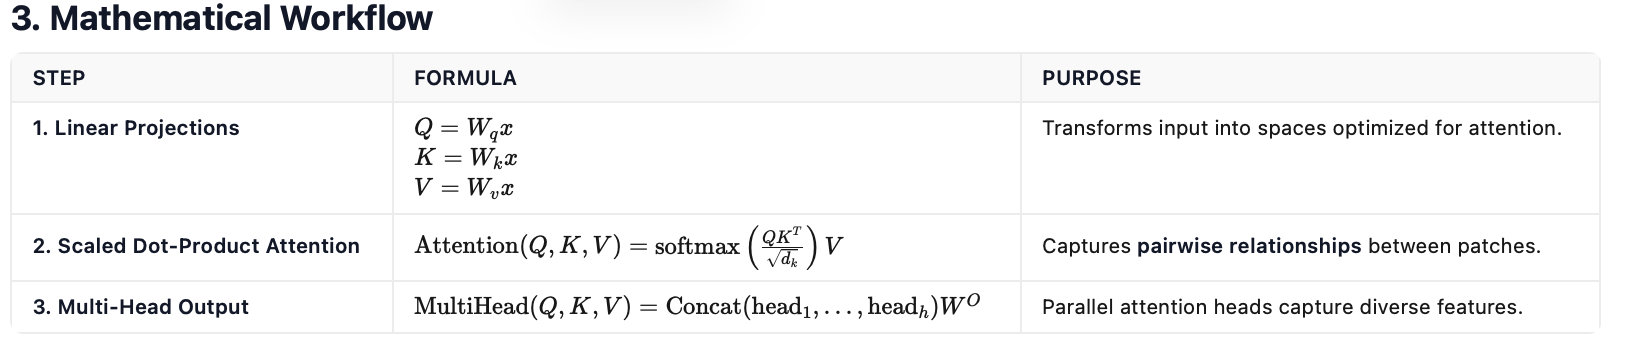

In [66]:
from IPython.display import Image, display

# Display the image
image_path = "data/Mat Workflow.png"
display(Image(filename=image_path))

In [71]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = 4   # Number of attention heads (e.g., 4)
        
        self.att = torch.nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True,   # Ensures shape: (batch, seq_len, dim)
        )

        # Linear projections for Query (Q), Key (K), Value (V)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

 
    def forward(self, x):
        q = self.q(x)  # Query
        k = self.k(x)  # Key
        v = self.v(x)  # Value

        # Compute Multi-Head Attention and return its output
        attn_output, _ = self.att(query=q, key=k, value=v)
        return attn_output

In [72]:
# Input tensor: (batch_size, sequence_length, dim)
x = torch.ones((1, 5, 128))  # Batch of 1, sequence length 5 (e.g., 5 patches), 128-D embeddings  

# Initialize the attention layer
attn = Attention(dim=128, n_heads=4, dropout=0.1)

# Forward pass: Self-Attention (x attends to itself)
output = attn(x)
print(output.shape)  # Output shape: torch.Size([1, 5, 128]) (same as input)

torch.Size([1, 5, 128])


Attention layer transforms an input tensor of shape [1, 5, 128] (batch_size=1, sequence_length=5, embedding_dim=128) into an output tensor of the same dimensions ([1, 5, 128]), but now each of the 5 patches contains context-aware features due to self-attention

1. Input Shape: [1, 5, 128]
 1: Batch size (1 image/sequence passed through at a time).
 5: Sequence length (e.g., 5 patch embeddings extracted from the image).
 128: Embedding dimension (each patch is represented as a 128-D vector).

2. The Self-Attention Process
In the forward method:
 a. Projections:
 Input x (5 patches) is transformed into 3 matrices:
 Query (Q): [1, 5, 128] — What each patch "asks" about other patches.
 Key (K): [1, 5, 128] — What each patch "contains."
          Why This Matters: Each patch can compute relationships with others via dot products (Q·K). 
 Value (V): [1, 5, 128] — Used to compute the final weighted output.
 
 b. Multi-Head Attention Computes:
 Step 1: Attention Scores (Q·K): Each pair of patches gets a score (e.g., how much patch 1 attends to patch 2).
 Step 2: Weighted Sum: Scores are applied to V to produce an output where each patch contains information from all other patches.


3. Why the Shape is Still [1, 5, 128]
 a. Consistent with Transformer Architecture: Self-attention outputs the same sequence length as input (5 patches).
 b. Meaning of the Output:
    Each patch’s 128-D vector now encodes context from all 5 patches.
    For example, if x represents patches of a cat image:
       Patch 1 (cat head): Now also knows about the tail (Patch 5) via attention weights.
       Patch 2 (legs): Now is aware of the background (Patch 3).

4. Mathematical Intuition
 Self-Attention Equation: Attention(Q,K,V)=softmax( ((QK^T) / rootsquare dk) V )

 Output Properties:
 Shape: [1, 5, 128] means:
 Batch size (1) is preserved.
 Sequence length (5) is preserved.
 Each patch’s 128-D vector now contains contextual information from the entire sequence (global relationship modeling).

In [77]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [78]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [76]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

## Residual Class
This ResidualAdd class implements residual connections (also known as "skip connections"), which are commonly used in Transformer architectures like Vision Transformers (ViT).
1. ResidualAdd Purpose
 Role: Wraps around any PyTorch module (e.g., Attention) to add a residual connection to it.
 Why?: Residual connections help mitigate vanishing gradients and allow deep networks (like Transformers) to learn effectively by enabling the original input to bypass one or more layers. This is crucial for stability and performance in deep architectures.

2. fn (Function/Module)
 What it is: The function/module being wrapped (e.g., Attention).
 Why?: The wrapped module (like Attention) computes the main transformation, but its output is combined with the original input (x).

3. forward(self, x, **kwargs)
 What it does:
 Preserves the residual (res = x) to allow the original input to skip the layer.
 Processes input x through self.fn (e.g., self-attention).
 Adds the residual back to the output (x += res).
 Returns the sum: x + residual.

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn  # The submodule (e.g., Attention) being wrapped
  
    def forward(self, x, **kwargs):
        res = x             # Save the original input (skip connection)
        x = self.fn(x, **kwargs)  # Process the input through the submodule (e.g., Attention)
        x += res            # Add the residual (original input) to the output
        return x            # Final output: x + residual

In [75]:
# Define the ResidualAdd class
class ResidualAdd(nn.Module):
	def __init__(self, fn):
		super().__init__()
		self.fn = fn  # The submodule (e.g., Attention) being wrapped
  
	def forward(self, x, **kwargs):
		res = x             # Save the original input (skip connection)
		x = self.fn(x, **kwargs)  # Process the input through the submodule (e.g., Attention)
		x += res            # Add the residual (original input) to the output
		return x            # Final output: x + residual

# Define an `Attention` module (e.g., Multi-Head Attention)  
att = Attention(dim=128, n_heads=4, dropout=0.)  

# Wrap `att` with a residual connection  
residual_att = ResidualAdd(att)  

# Forward pass  
x = torch.ones((1, 5, 128))  # Input shape: [batch=1, seq_len=5, dim=128]  
output = residual_att(x)  

print(output.shape)  
# Output: torch.Size([1, 5, 128])  # Same as input, but now context-aware

torch.Size([1, 5, 128])


In [79]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=37, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])


model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))


=== Initializing PatchEmbedding ===
Input channels: 3
Patch size: 4
Embedding size: 32
Projection layer initialized:
Sequential(
  (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
  (1): Linear(in_features=48, out_features=32, bias=True)
)
ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_featur

tensor([[ 0.1480, -0.6357,  0.2528, -0.0022, -0.1521, -0.1882,  0.5728,  0.2323,
          0.0062,  0.2596,  0.7851, -0.4279,  0.2707, -0.3665,  0.4626, -0.4461,
          0.6520, -1.5598, -0.4661,  0.3911, -0.5657,  1.0376,  1.7143, -0.0484,
          1.4108,  0.0976,  0.2171,  0.3570,  0.3662, -0.3544, -0.0473, -0.2256,
         -0.4001, -0.0972, -0.2340, -0.6649,  1.2325]],
       grad_fn=<AddmmBackward0>)

## Training

In [80]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [92]:
# import torch.optim as optim
# import numpy as np

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = ViT().to(device)
# optimizer = optim.AdamW(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# for epoch in range(5): #should be 1000
#     epoch_losses = []
#     model.train()
#     for step, (inputs, labels) in enumerate(train_dataloader):
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         # Ensure labels are within the valid range
#         if labels.max() >= model.head[-1].out_features or labels.min() < 0:
#             raise ValueError(f"Invalid label value detected. Labels should be in the range [0, {model.head[-1].out_features - 1}].")
        
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         epoch_losses.append(loss.item())
#     if epoch % 5 == 0:
#         print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))
#         epoch_losses = []
#         # Something was strange when using this?
#         # model.eval()
#         for step, (inputs, labels) in enumerate(test_dataloader):
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             epoch_losses.append(loss.item())
#         print(f">>> Epoch {epoch} test loss: ", np.mean(epoch_losses))